In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from osgeo import gdal, ogr, gdal_array
import dask
import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.utils import geometry
import os
#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools, BandIndices, DEADataHandling
from load_data import load_data
from transform_tuple import transform_tuple
from query_from_shp import query_from_shp
from rsgislib.segmentation import segutils
from rasterstats import zonal_stats
from imageSeg import imageSeg
import fiona
import rasterio.features

import warnings
warnings.filterwarnings('ignore')

In [11]:
# where is your data and results folder?
results = "results/"
# data = 'data/'

sensors = ['ls5','ls7','ls8']

#are we using a polygon to mask the AOI?
shp_fpath = 'data/spatial/murrumbidgee_boundingbox.shp'

#Input your area of interest's name, coords, and 
#the year you're interested in?
AOI = 'Murrum_randomForest'
year = 'Winter2013'

time_period = ('2014-05-01', '2014-09-30')

#What thresholds should I use?
threshold = 0.8
wofs_theshold = 0.15
#-----------------------------------------

In [12]:
#Creating a folder to keep things neat
directory = results + AOI + "_" + year
if not os.path.exists(directory):
    os.mkdir(directory)

results = results + AOI + "_" + year + "/"

In [13]:
#set up query
query = query_from_shp(shp_fpath, time_period[0], time_period[1], dask_chunks = 500)
#landsat
# dc = datacube.Datacube(app='dc_name')
# landsat = DEADataHandling.load_clearlandsat(dc,query=query, sensors=sensors, product='nbart',
#                        masked_prop=0.75)

landsat = load_data(dc_name = 'irrigated_areas', sensors=sensors, export_name = 'fh',query=query)
#wofs
# dc = datacube.Datacube(app='wofs')
# del query['time'] 
# wofs_alltime = dc.load(product = 'wofs_summary', **query)

#masking the returned array to the polygon area
with fiona.open(shp_fpath) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

mask = rasterio.features.geometry_mask([geom.to_crs(landsat.geobox.crs) for geoms in [geom]],
                                           out_shape=landsat.geobox.shape,
                                           transform=landsat.geobox.affine,
                                           all_touched=False,
                                           invert=True)
# Mask the xarrays
landsat = landsat.where(mask)
#wofs_alltime = wofs_alltime.where(mask)
#datacube.storage.storage.write_dataset_to_netcdf(landsat, results + AOI "_" + year + '.nc')

ls5_loading...
ls5_loaded
ls7_loading...
ls7_loaded
ls8_loading...
ls8_loaded


In [17]:
#band indices calculation
def ndvi_ufunc(ds):
    def ndvi_func(nir, red):
        return ((nir - red)/(nir + red))
    
    return xr.apply_ufunc(
        ndvi_func, ds.nir, ds.red,
        dask='parallelized',
        output_dtypes=[float])

def brightness_ufunc(ds):
    def brightness_func(g,r,nir,swir):
        return (g**2 + r**2 + nir**2 + swir**2)**(1/2.0)
    
    return xr.apply_ufunc(
        brightness_func, ds.green,ds.red, ds.nir, ds.swir1,
        dask='parallelized',
        output_dtypes=[float])

NDVI_landsat = ndvi_ufunc(landsat)
brightness_landsat = brightness_ufunc(landsat)
NDMI_landsat = BandIndices.calculate_indices(landsat, index='NDMI-nir')

#calculate NDVI & NDMI stats
print('calculating NDVI & NDMI stats')
NDVI_max = NDVI_landsat.max('time').rename('NDVI_max')
NDVI_mean = NDVI_landsat.mean('time').rename('NDVI_mean')
NDVI_std = NDVI_landsat.std('time').rename('NDVI_std')
NDVI_min = NDVI_landsat.min('time').rename('NDVI_min')
NDVI_range = NDVI_max - NDVI_min
NDVI_range = NDVI_range.rename('NDVI_range')

NDMI_max = NDMI_landsat.max('time').rename('NDMI_max')
NDMI_mean = NDMI_landsat.mean('time').rename('NDMI_mean')
NDMI_std = NDMI_landsat.std('time').rename('NDMI_std')
NDMI_min = NDMI_landsat.min('time').rename('NDMI_min')

#brightness stats
print('calculating brightness stats')
brightness_max = brightness_landsat.max('time').rename('brightness_max')
brightness_mean = brightness_landsat.mean('time').rename('brightness_mean')
brightness_std = brightness_landsat.std('time').rename('brightness_std')
brightness_min = brightness_landsat.min('time').rename('brightness_min')

print('calculating rate and argmax,min')
NDVI_landsat_resample = NDVI_landsat.resample(time='M').mean('time')
def nanarg(xarr, dim, stat):
    """
    deals with all-NaN slices by filling those locations
    with an integer and then masking the offending cells
    after computing nanargmin(max)
    """
    #generate a mask where entire all values along a dimension are NaN
    mask = xarr.min(dim=dim, skipna=True).isnull()
    if stat=='max':
        y = xarr.fillna(-99.0)
        y = y.argmax(dim=dim, skipna=True).astype(float)
        y = y.where(~mask)
        return y
    if stat == 'min':
        y = xarr.fillna(100)
        y = y.argmin(dim=dim, skipna=True).astype(float)
        y = y.where(~mask)
        return y

timeofmax = nanarg(NDVI_landsat_resample,dim ='time', stat='max')
timeofmin = nanarg(NDVI_landsat_resample,dim ='time', stat='min')

rate = (NDVI_max-NDVI_min)/(timeofmax - timeofmin)
rate = rate.where(~np.isnan(rate<=3), other=3) #remove unreasonable values

The formula we are using is (nir - swir1)/(nir + swir1)
calculating NDVI & NDMI stats


In [18]:
xray_list = [NDVI_max, NDVI_mean, NDVI_std, NDVI_min, NDVI_range,
             NDMI_max, NDMI_mean, NDMI_std, NDMI_min,timeofmax, timeofmin, rate,
             brightness_max, brightness_mean, brightness_std, brightness_std]
names = ['NDVI_max', 'NDVI_mean', 'NDVI_std', 'NDVI_min', 'NDVI_range',
         'NDMI_max', 'NDMI_mean', 'NDMI_std', 'NDMI_min','timeofmax', 'timeofmin','rate',
            'brightness_max', 'brightness_mean', 'brightness_std', 'brightness_std']

In [20]:
#convert to numpy arrays (SLOW BECAUSE DASK ARRAYS ARE COMPUTED)
x,y = NDVI_max.shape
z = len(xray_list)
img = np.zeros((x,y,z))
for b,c in zip(xray_list, range(img.shape[2])):
    print('adding slice to array...')
    img[:, :, c] = b.values 
    
img_noNaNs = np.nan_to_num(img) #remove nans as they f/w classifier
np.save(results + 'img_noNaNs_winter2014.npy', img_noNaNs) #save it as binary

adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...
adding slice to array...


In [59]:
# If we need to load back in the trained RF model:
from joblib import load
rf = load(results + 'murrumbidgee_rfModel.joblib')

# img_noNaNs = np.where(img_noNaNs >1.0e+307, 3, img_noNaNs) #run this if rate is being a bastard
# Take our full image, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img_noNaNs.shape[0] * img_noNaNs.shape[1], img_noNaNs.shape[2])

img_as_array = img_noNaNs[:, :, :z].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img_noNaNs.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
print('generating prediction')
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img_noNaNs[:, :, 0].shape)

Reshaped from (1493, 2379, 16) to (3551847, 16)
generating prediction


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   46.8s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  1.2min finished


Text(0.5, 1.0, 'Irrigation Pixels Only')

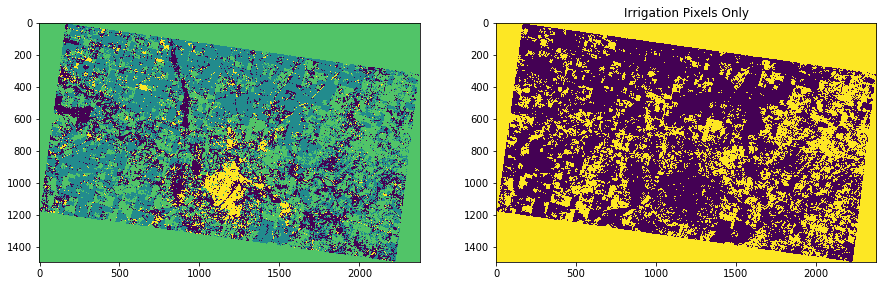

In [60]:
#generate a plot of the predictions
import matplotlib.patches as mpatches
values = np.unique(class_prediction.ravel())

plt.figure(figsize=(15,15))
plt.subplot(121)
im = plt.imshow(class_prediction, interpolation='none')
# colors = [im.cmap(im.norm(value)) for value in values]
# patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.subplot(122)
irr = np.where(class_prediction==430, 1, 0)
plt.imshow(irr)
plt.title('Irrigation Pixels Only')

In [61]:
#export out the results
transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
SpatialTools.array_to_geotiff(results + AOI + "_" + year + "classpredict_handtrain_winter2014.tif",
              class_prediction, geo_transform = transform, 
              projection = projection, nodata_val=0)

In [62]:
class_predict = xr.open_rasterio(results + AOI + "_" + year + "classpredict_handtrain_winter2014.tif")
class_predict = class_predict.squeeze()

gdf = gpd.read_file(results + AOI + '_' + year + '_SEGpolygons.shp')
#calculate majority values inside segments
gdf['majority'] = pd.DataFrame(zonal_stats(vectors=gdf['geometry'], raster=results + AOI + "_" + year + "classpredict_handtrain_winter2014.tif", stats='majority'))['majority']
#calculate area of polygons
gdf['area'] = gdf['geometry'].area
#filter by area and majority values
smallArea = gdf['area'] <= 5500000
irrigated = gdf['majority'] == 430.0 #filtering for irrigated areas only
gdf = gdf[smallArea&irrigated]
#export shapefile
gdf.to_file(results + AOI + "_" + year + "_Irrigated_winter2014.shp")

#get the transform and projection of our gtiff
transform, projection = transform_tuple(class_predict, (class_predict.x, class_predict.y), epsg=3577)
#find the width and height of the xarray dataset we want to mask
width,height = class_predict.shape
# rasterize vector
gdf_raster = SpatialTools.rasterize_vector(results + AOI + "_" + year + "_Irrigated_winter2014.shp",
                                           height, width, transform, projection, raster_path=results + AOI + "_" + year + "_Irrigated.tif")

Exporting raster to results/Murrum_randomForest_Winter2013/Murrum_randomForest_Winter2013_Irrigated.tif


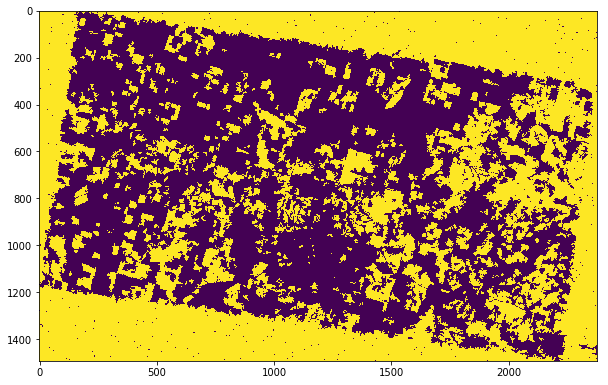

In [63]:
plt.figure(figsize=(10,10))
plt.imshow(gdf_raster, interpolation='none')